## Setup

Usually you would need to export the location of the data, and the config files to `PISA_RESOURCES`. For this example however, the data is inside our package.

In [1]:
import numpy as np
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt
import copy
import pisa
from pisa.core.distribution_maker import DistributionMaker
from pisa.analysis.analysis import Analysis
from pisa import FTYPE, ureg

<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


## Model

We can now instantiate the `model` (given our configs) that we later fit to data. This now containes two `Pipelines` in a `DistributionMaker`, one for our neutrinos, and one for the background muons.

In [2]:
model = DistributionMaker(["settings/pipeline/IceCube_3y_neutrinos.cfg"])

[ WARNING] /data/user/jweldert/miniconda3/envs/pisa/lib/python3.9/site-packages/pint/quantity.py:221: BehaviorChangeWarning: The way Pint handles NumPy operations has changed with the
implementation of NEP 18. Unimplemented NumPy operations will now fail instead of making
assumptions about units. Some functions, eg concat, will now return Quanties with units, where
they returned ndarrays previously. See https://github.com/hgrecco/pint/pull/905.

To hide this warning, wrap your first creation of an array Quantity with
warnings.catch_warnings(), like the following:

import numpy as np
import warnings
from pint import Quantity

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Quantity([])

To disable the new behavior, see
https://www.numpy.org/neps/nep-0018-array-function-protocol.html#implementation

  warnings.warn(array_function_change_msg, BehaviorChangeWarning)



Our model has a number of free parameters, that will be used in our fit to the data

In [3]:
model.params.free

name,value,nominal_value,range,prior,units,is_fixed
nue_numu_ratio,1,1,"[0.5, 1.5]",+/- 0.05,dimensionless,False
Barr_uphor_ratio,0,0,"[-3.0, 3.0]",+/- 1.0,dimensionless,False
Barr_nu_nubar_ratio,0,0,"[-3.0, 3.0]",+/- 1.0,dimensionless,False
delta_index,0,0,"[-0.5, 0.5]",+/- 0.1,dimensionless,False
theta13,8.5,8.5,"[7.85, 9.1]",+/- 0.205,degree,False
theta23,42.3,42.3,"[31, 59]",uniform,degree,False
deltam31,0.002457,0.002457,"[0.001, 0.007]",uniform,electron_volt ** 2,False
aeff_scale,1,1,"[0.0, 3.0]",uniform,dimensionless,False
nutau_norm,1,1,"[-1.0, 8.5]",uniform,dimensionless,False
nu_nc_norm,1,1,"[0.5, 1.5]",+/- 0.2,dimensionless,False


## Retrieve Outputs

In [4]:
fake_data = model.get_outputs(return_sum=True)

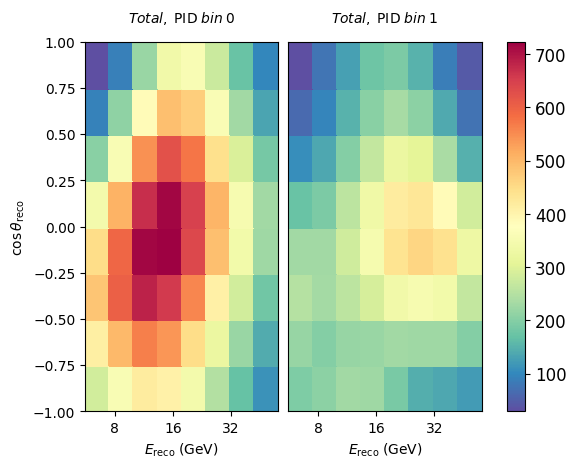

In [5]:
fake_data.plot()

## Do MCMC sampling

In [21]:
nwalkers = 50
burnin = 30
nsteps = 50

Serial mode from analysis class (very slow)

In [ ]:
ana = Analysis()
scaled_chain = ana.MCMC_sampling(fake_data, model, 'chi2', nwalkers, burnin, nsteps)

Multi CPU version

In [19]:
import emcee
from multiprocessing import Pool

from pisa.analysis.analysis import METRICS_TO_MAXIMIZE
from pisa.core.param import ParamSet

In [ ]:
def func(scaled_param_vals, bounds, metric):
    if np.any(scaled_param_vals > np.array(bounds)[:, 1]) or np.any(scaled_param_vals < np.array(bounds)[:, 0]):
        return -np.inf
    sign = +1 if metric in METRICS_TO_MAXIMIZE else -1
    model._set_rescaled_free_params(scaled_param_vals) # pylint: disable=protected-access
    hypo_asimov_dist = model.get_outputs(return_sum=True)
    metric_val = (
        fake_data.metric_total(expected_values=hypo_asimov_dist, metric=metric)
        + model.params.priors_penalty(metric=metric)
    )
    return sign*metric_val

In [22]:
ndim = len(model.params.free)
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

params_truth = model.params.free
x0 = np.array([p._rescaled_value for p in params_truth])
bounds = np.repeat([[0,1]], len(x0), axis=0)

In [23]:
with Pool(10) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, func, pool=pool,
        args=[bounds, 'mod_chi2']
    )
    
    print('Burn in')
    pos, prob, state = sampler.run_mcmc(p0, burnin, progress=True)
    flatchainburnin = sampler.flatchain

    sampler.reset()
    print('Main sampling')
    sampler.run_mcmc(pos, nsteps, progress=True)

Burn in


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [05:14<00:00, 10.50s/it]


Main sampling


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [10:54<00:00, 13.09s/it]


In [24]:
flatchain = sampler.flatchain
scaled_chain = np.full_like(flatchain, np.nan, dtype=FTYPE)
param_copy = ParamSet(model.params.free)

for s, sample in enumerate(flatchain):
    for dim, rescaled_val in enumerate(sample):
        param = param_copy[dim]
        param._rescaled_value = rescaled_val
        val = param.value.m
        scaled_chain[s, dim] = val

## Plot

Text(0.5, 1.0, 'deltam31')

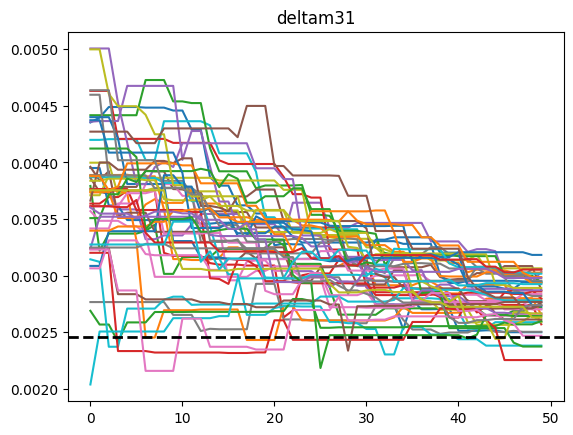

In [25]:
N = 6
for i in range(nwalkers):
    plt.plot(scaled_chain[i::nwalkers, N])
plt.axhline(model.params.free.nominal_values[N].m, color='black', linewidth=2, linestyle='--')
plt.title(model.params.free.names[N])

Text(0.5, 1.0, 'deltam31')

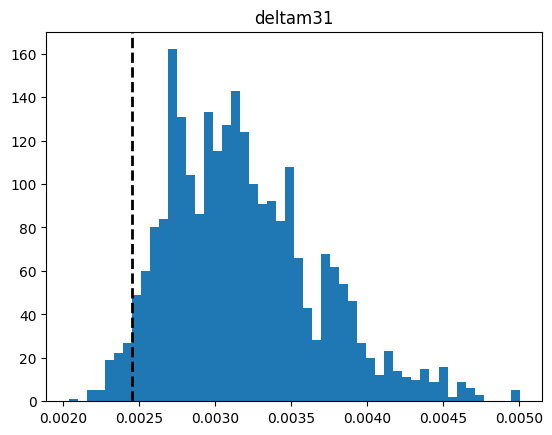

In [26]:
plt.hist(scaled_chain[:,N], 50)
plt.axvline(model.params.free.nominal_values[N].m, color='black', linewidth=2, linestyle='--')
plt.title(model.params.free.names[N])

In [27]:
import pygtc

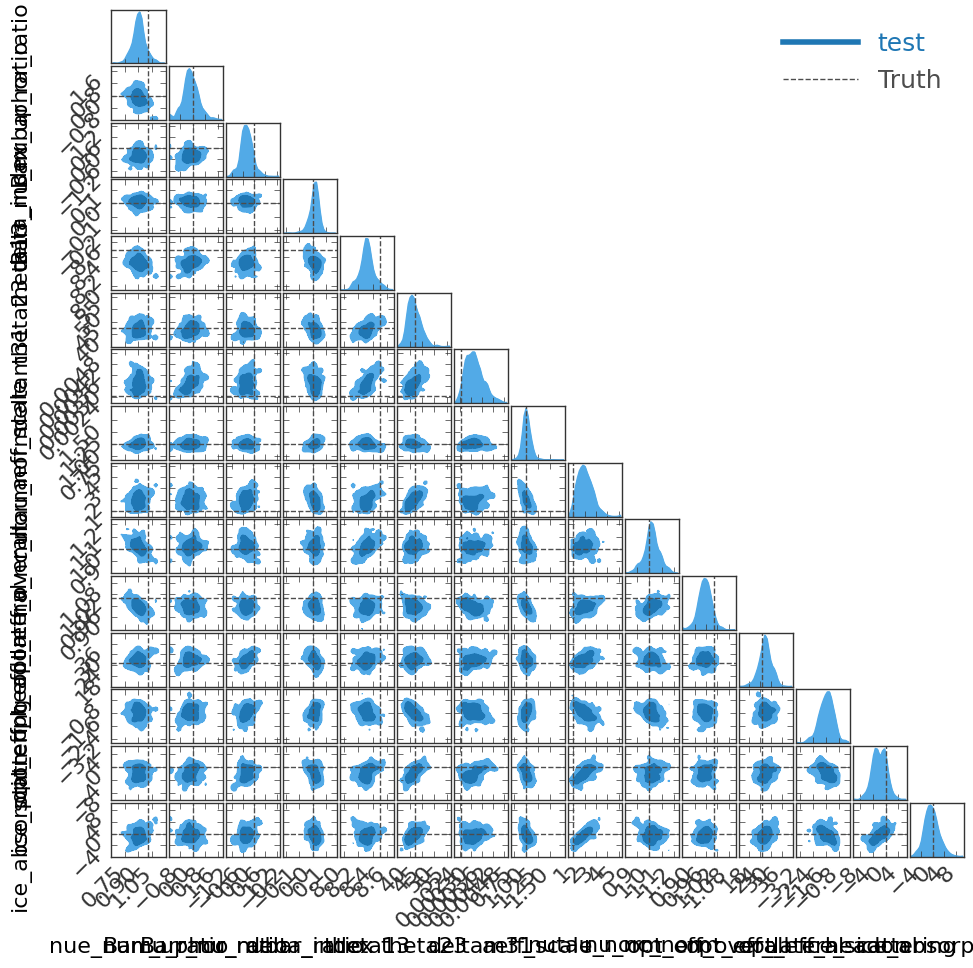

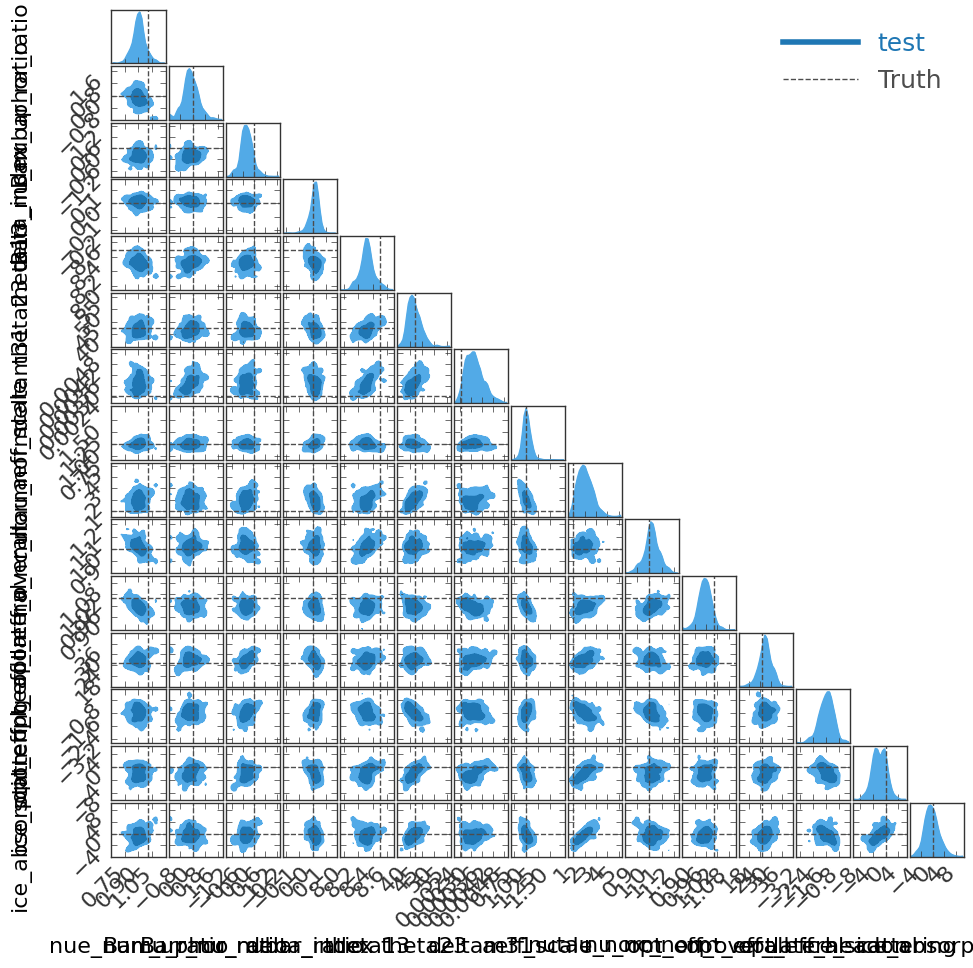

In [28]:
pygtc.plotGTC(chains=scaled_chain,
              paramNames=model.params.free.names,
              chainLabels='test',
              truths=np.array([p.nominal_value.m for p in params_truth]),
              truthLabels='Truth',
              #priors=priors,
              #paramRanges=paramRanges,
              figureSize=11,
              panelSpacing='loose',
              legendMarker='All',
              customLabelFont={'size':16},
              customLegendFont={'size':18},
              customTickFont={'size':16},
             )